# Técnicas de Machine Learning para Classificação Supervisionada de Contas Bots do Twitter.

## FIA LABDATA - Turma 13

### Fabio Daleffi

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [60]:
df_original = pd.read_csv('classified_twitter_accounts.csv')

In [61]:
df_original.columns

Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'lang',
       'default_profile', 'default_profile_image', 'geo_enabled', 'protected',
       'verified', 'classification', 'dataset', 'screen_name_total_len',
       'screen_name_num_len', 'name_total_len', 'name_num_len', 'is_url_null',
       'is_location_null', 'profile_banner_url_null', 'profile_image_url_null',
       'description_null'],
      dtype='object')

In [62]:
df_original.shape

(14368, 25)

In [63]:
# DROP FEATURES LIST

#ALTA CARDINALIDADE
alta_card = ['id','name', 'screen_name']

# ALTA CORRELACAO (IDENTIFICADA NA ANALISE EXPLORATORIA)
correlacao = ['listed_count']

construidas = [
    'screen_name_total_len',  
    'screen_name_num_len',       
    'name_total_len',            
    'name_num_len',              
    'is_url_null',               
    'is_location_null',          
    'profile_banner_url_null',   
    'profile_image_url_null',    
    'description_null'
] 


drop_features = alta_card + correlacao + construidas

# VARIAVEIS DE CONTROLE DO DATASET
drop_features.append('dataset')

df_accounts = df_original.drop(drop_features, axis=1)

In [64]:
# target
df_accounts['target'] = np.where(df_accounts.classification == "bot", 1, 0)
df_accounts.drop('classification', axis=1, inplace=True)

In [65]:
df_accounts.dtypes

statuses_count            int64
followers_count           int64
friends_count             int64
favourites_count          int64
lang                     object
default_profile            bool
default_profile_image      bool
geo_enabled                bool
protected                  bool
verified                   bool
target                    int32
dtype: object

In [66]:
df_accounts.shape

(14368, 11)

In [67]:
df_accounts.describe()

,statuses_count,followers_count,friends_count,favourites_count,target
count,14368.000000,1.436800e+04,14368.000000,14368.000000,14368.000000
mean,5063.190910,8.682774e+02,589.318834,1145.288280,0.758213
std,17493.409898,2.688472e+04,2665.832959,6036.894173,0.428181
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,31.000000,6.000000e+00,42.000000,0.000000,1.000000
50%,63.000000,2.500000e+01,250.000000,0.000000,1.000000
75%,1365.250000,3.320000e+02,538.000000,9.000000,1.000000
max,399555.000000,2.991573e+06,211890.000000,313954.000000,1.000000


# CATEGORIZANDO AS VARIÁVEIS

In [68]:
df = df_accounts.copy()

In [69]:
df['statuses_count'] = pd.cut(df.statuses_count, bins=[-1,31,63,1365,399555], labels=[
     '1 - DE 0 ATE 31'
    ,'2 - DE 32 ATE 63'
    ,'3 - DE 64 ATE 1365'
    ,'4 - ACIMA DE 1365'
] )

In [70]:
df['followers_count'] = pd.cut(df.followers_count, bins=[-1,6,25,332,2991573], labels=[
     '1 - DE 0 ATE 6'
    ,'2 - DE 7 ATE 25'
    ,'3 - DE 26 ATE 332'
    ,'4 - ACIMA DE 332'
] )

In [71]:
df['friends_count'] = pd.cut(df.friends_count, bins=[-1,42,250,538,211890], labels=[
     '1 - DE 0 ATE 42'
    ,'2 - DE 43 ATE 250'
    ,'3 - DE 251 ATE 538'
    ,'4 - ACIMA DE 538'
])

In [72]:
df['favourites_count'] = pd.cut(df.favourites_count, bins=[-1,9,313954], labels=[
     '1 - DE 0 ATE 9'
    ,'2 - ACIMA DE 9'
])

In [73]:
df['lang'] = np.where(df.lang == "en", 'ENGLISH', 'OTHERS')
df['lang'] = df['lang'].astype('category')

# Criar Dummies

In [74]:
cat_vars = df.drop('target', axis=1).columns

for var in cat_vars:

    cat_list='var' +'_'+ var
    cat_list = pd.get_dummies(df[var], prefix = var, drop_first=True)
    df=df.join(cat_list)

df.drop(cat_vars, axis = 1, inplace = True)

# Decision Tree

In [75]:
X = df.drop('target', axis = 1)
y = df.target

# BACKWARD FEATURE REMOVAL
drop_list = [
    'protected_True',
    'verified_True',
    'statuses_count_2 - DE 32 ATE 63',
    'default_profile_image_True'
]

X.drop(drop_list, axis = 1, inplace = True)

## Train Test Split

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [77]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3, min_samples_split=50)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [78]:
from sklearn.metrics import accuracy_score

y_train_predictions = dt.predict(X_train)
y_teste_predictions = dt.predict(X_test)
# print(accuracy_score(y_test, y_teste_predictions))
# print(accuracy_score(y_train, y_train_predictions))


print('Accuracy no treino: {:.2f}'.format(accuracy_score(y_test, y_teste_predictions)))
print('Accuracy no teste: {:.2f}'.format(accuracy_score(y_train, y_train_predictions)))

Accuracy no treino: 0.97
Accuracy no teste: 0.97


In [79]:
columns = X_test.columns
feature_importances = pd.Series(dt.feature_importances_)

df_feature_importances = pd.DataFrame({"column":columns,"feature_importances" : feature_importances})
df_feature_importances.sort_values(by = 'feature_importances', ascending=False).head(10)

,column,feature_importances
9,favourites_count_2 - ACIMA DE 9,0.986911
13,geo_enabled_True,0.007899
10,lang_OTHERS,0.003977
2,statuses_count_4 - ACIMA DE 1365,0.000678
14,protected_True,0.000535
0,statuses_count_2 - DE 32 ATE 63,0.000000
1,statuses_count_3 - DE 64 ATE 1365,0.000000
3,followers_count_2 - DE 7 ATE 25,0.000000
4,followers_count_3 - DE 26 ATE 332,0.000000
5,followers_count_4 - ACIMA DE 332,0.000000


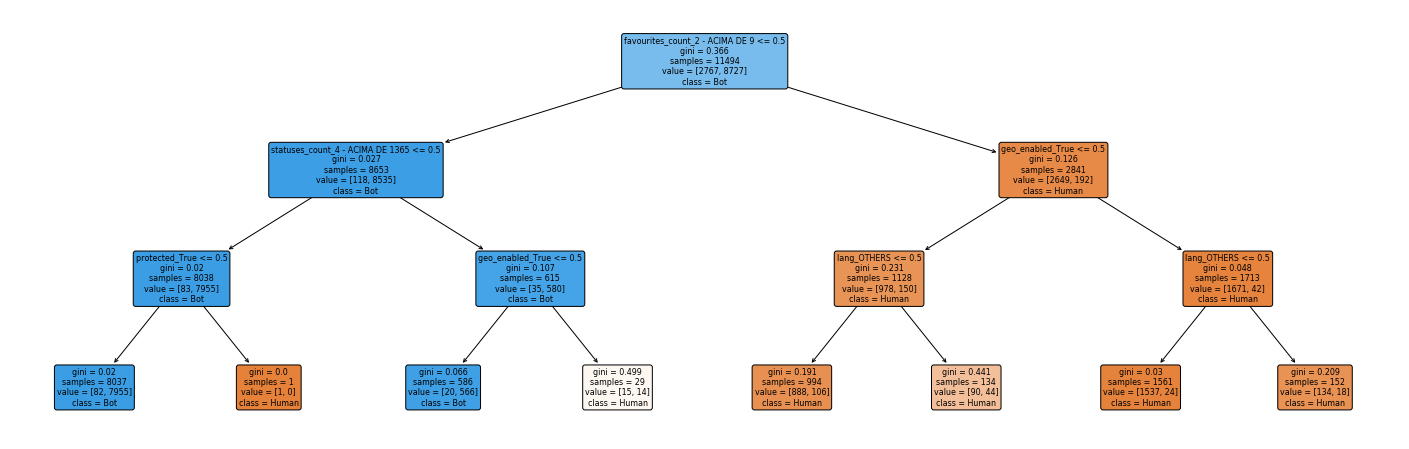

In [80]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(25, 8))

plot_tree(dt, ax=ax, filled=True, feature_names=X.columns, class_names=['Human', 'Bot'], rounded=True);

# Métricas Treino

TN | FP <br>
FN | TP

Matriz de confusão do SKLearn é reversa

In [81]:
from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_train, y_train_predictions)
print(confusion_matrix_train)

[[2665  102]
 [ 206 8521]]


In [58]:
TP =7807 #8521
TN =1737 #2664
FP = 1030#103
FN = 920#206

Accuracy    = (TP + TN) / (TP+TN+FP+FN) * 100
Precision   = (TP/(TP+FP)) * 100
Specificity = (TN/(FP+TN)) * 100
Recall      = (TP/(TP+FN)) * 100

print('Accuracy: {:.2f}'.format(Accuracy))
print('Precision: {:.2f}'.format(Precision))
print('Specificity: {:.2f}'.format(Specificity))
print('Recall(Sensitivity): {:.2f}'.format(Specificity))

Accuracy: 83.03
Precision: 88.34
Specificity: 62.78
Recall(Sensitivity): 62.78


# Métricas Teste

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_teste_predictions)
print(confusion_matrix)

[[ 681   26]
 [  62 2105]]


In [29]:
TP = 2105
TN = 681
FP = 26
FN = 62

Accuracy    = (TP + TN) / (TP+TN+FP+FN) * 100
Precision   = (TP/(TP+FP)) * 100
Specificity = (TN/(FP+TN)) * 100
Recall      = (TP/(TP+FN)) * 100

print('Accuracy: {:.2f}'.format(Accuracy))
print('Precision: {:.2f}'.format(Precision))
print('Specificity: {:.2f}'.format(Specificity))
print('Recall(Sensitivity): {:.2f}'.format(Specificity))

Accuracy: 96.94
Precision: 98.78
Specificity: 96.32
Recall(Sensitivity): 96.32
